In [1]:
# * * * * * * * * * * * * * * * *
# Configuration
# * * * * * * * * * * * * * * * *
EXPERIMENT_NUM='5'

DATASET_DIR = '/workspace/datasets'
OUTPUT_DIR = '/workspace/outputs'

TARGET_METRIC='mean_temp'
SAMPLE_SIZE=2500

DEVICE = "cpu"

LATENT_DIM=4
BATCH_SIZE=200
EPOCHS=100
BETA=0.2
LEARNING_RATE=1e-3
GAMMA=0.1

INPUT_DIM=(1,120)

In [2]:
import os
from sklearn.preprocessing import StandardScaler
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from torchinfo import summary

from lunar_vae import VAE, train, SampleLatentSpace, VisualizeLatentSpace
from utils import (
    CollectStatisticsFromProfilesV1,
    ConvertProfileListToCsv,
    CreateProfileSubset,
    GenerateDensityPlot,
    GetDataMetrics,
    GetMeanLatentValues,
    LoadProfileList,
    LoadTemperatureDataV1,
    PlotHistograms,
    PlotComparativeHistograms,
    PlotLosses,
    PrintAndLog,
    SaveLossesToCSV,
    SetupOutputDir,
    SplitAndNormalizeData,
)

# * * * * * * * * * * * * * * * *
# Setting Variables
# * * * * * * * * * * * * * * * *
PROFILES_DIR = os.path.join(DATASET_DIR, f'profiles-v1', f'profiles-v1-jsons')
ORIGINAL_PROFILE_LIST_JSON = '/workspace/outputs/profiles-v1/profiles_v1_experiment_2_20250326_0344/profile_list_v1_in_range.json'
LABEL = f'profiles_v1_experiment_{EXPERIMENT_NUM}'
BINNED_PROFILE_LIST = os.path.join(DATASET_DIR, 'profiles-v1', 'profile_list_v1_binned.json')

# * * * * * * * * * * * * * * * *
# Make Directory
# * * * * * * * * * * * * * * * *
model_dir = SetupOutputDir(OUTPUT_DIR, parent_folder=LABEL, sub_folders=["reconstruction_images"])
print(f"Created directory {model_dir}")

Created directory /workspace/outputs/profiles_v1_experiment_5_20250331_0229


In [3]:
# * * * * * * * * * * * * * * * *
# Create Subset by Metric
# * * * * * * * * * * * * * * * *
SUBSET_PROFILE_LIST = os.path.join(model_dir, f'profile_list_v1_{TARGET_METRIC}_{SAMPLE_SIZE}.json')
CreateProfileSubset(BINNED_PROFILE_LIST, SUBSET_PROFILE_LIST, TARGET_METRIC, SAMPLE_SIZE)

In [4]:
# * * * * * * * * * * * * * * * *
# Load Profile List
# * * * * * * * * * * * * * * * *
profile_list = LoadProfileList(SUBSET_PROFILE_LIST)

In [5]:
# * * * * * * * * * * * * * * * *
# Convert to CSV
# * * * * * * * * * * * * * * * *
csv_path = ConvertProfileListToCsv(PROFILES_DIR, profile_list, model_dir)

Processing Profiles: 100%|██████████| 78430/78430 [00:18<00:00, 4306.86it/s]

Saved 78430 profiles to /workspace/outputs/profiles_v1_experiment_5_20250331_0229/20250331-dataset.csv


In [6]:
# * * * * * * * * * * * * * * * *
# Load Temp Data
# * * * * * * * * * * * * * * * *
temp_data = LoadTemperatureDataV1(csv_path, DEVICE)

Loading Profiles: 78430it [00:02, 27381.34it/s]


Saved figure to /workspace/outputs/profiles_v1_experiment_5_20250331_0229/density_plot.png


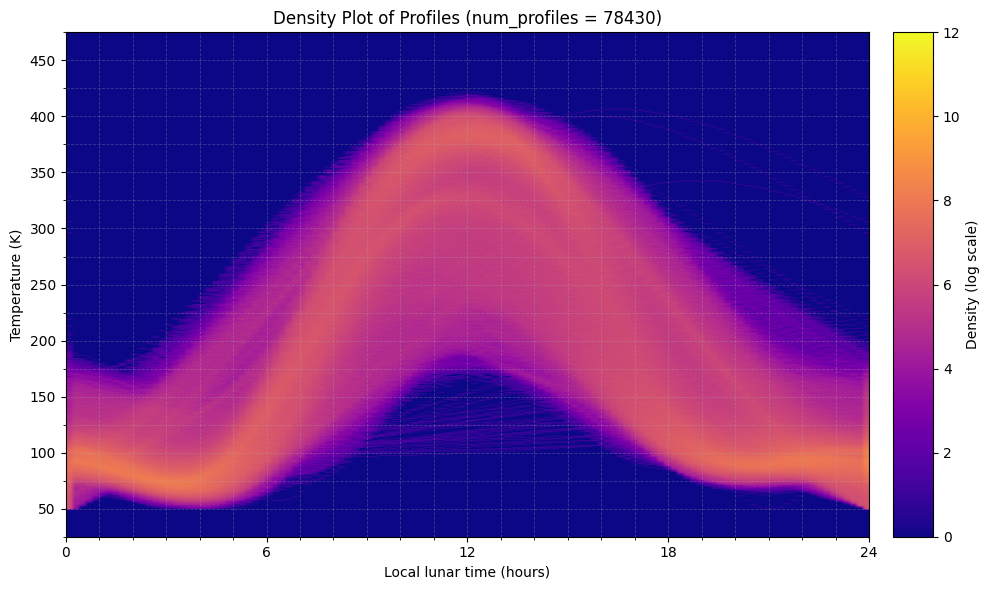

In [7]:
# * * * * * * * * * * * * * * * *
# Generate Density Plot
# * * * * * * * * * * * * * * * *
GenerateDensityPlot(temp_data, model_dir)

In [8]:
# * * * * * * * * * * * * * * * *
# Load Original Profile List
# * * * * * * * * * * * * * * * *
original_profile_list = LoadProfileList(ORIGINAL_PROFILE_LIST_JSON)

Saved figure to /workspace/outputs/profiles_v1_experiment_5_20250331_0229/histogram_max_temp.png


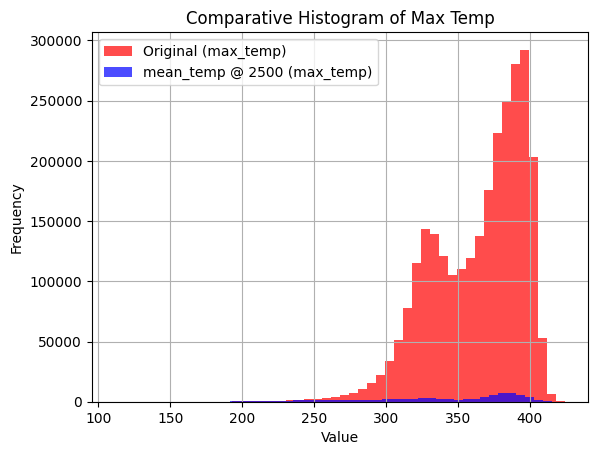

Saved figure to /workspace/outputs/profiles_v1_experiment_5_20250331_0229/histogram_min_temp.png


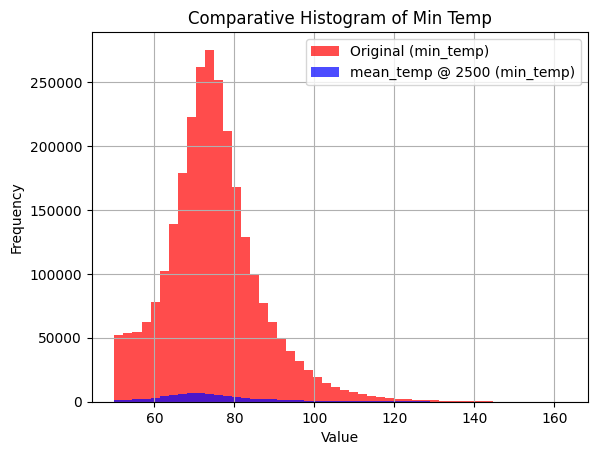

Saved figure to /workspace/outputs/profiles_v1_experiment_5_20250331_0229/histogram_mean_temp.png


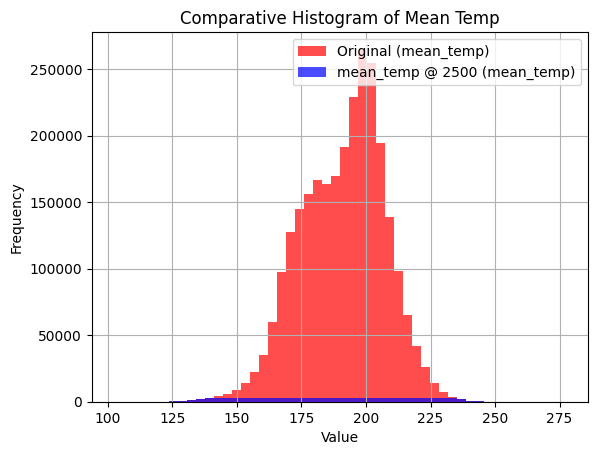

Saved figure to /workspace/outputs/profiles_v1_experiment_5_20250331_0229/histogram_std_temp.png


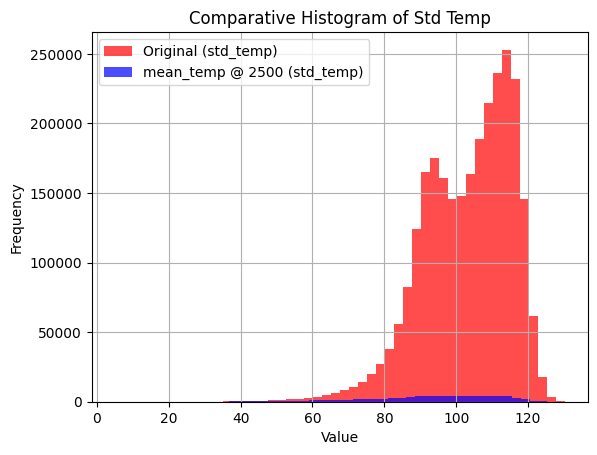

In [9]:
# * * * * * * * * * * * * * * * *
# Generate Histograms
# * * * * * * * * * * * * * * * *
statistics_original = CollectStatisticsFromProfilesV1(PROFILES_DIR, original_profile_list)
statistics_subset = CollectStatisticsFromProfilesV1(PROFILES_DIR, profile_list)
PlotComparativeHistograms(statistics_original, statistics_subset, labels=("Original", f"{TARGET_METRIC} @ {SAMPLE_SIZE}"), output_dir=model_dir)

In [10]:
# * * * * * * * * * * * * * * * *
# Training Log
# * * * * * * * * * * * * * * * 
log_filepath = os.path.join(model_dir, 'training.log')

# * * * * * * * * * * * * * * * *
# Data Prep
# * * * * * * * * * * * * * * * *
x_data_mean, x_data_std, x_data_min, x_data_max = GetDataMetrics(temp_data)

PrintAndLog(log_filepath, "Data Metrics:\n")
PrintAndLog(log_filepath, f"\tMean: {x_data_mean:.4f}\n")
PrintAndLog(log_filepath, f"\tSTD: {x_data_std:.4f}\n")
PrintAndLog(log_filepath, f"\tMin Temp: {x_data_min:.4f}\n")
PrintAndLog(log_filepath, f"\tMax Temp: {x_data_max:.4f}\n")

# Normalize Data (Mean=0, STD=1)
scaler = StandardScaler()
train_loader, val_loader, test_loader = SplitAndNormalizeData(
	temp_data, scaler, BATCH_SIZE, DEVICE)

PrintAndLog(log_filepath, "Datasets:\n")
PrintAndLog(
	log_filepath,
	f"\tTraining Data: {len(train_loader.dataset)}\n")
PrintAndLog(
	log_filepath,
	f"\tValidation Data: {len(val_loader.dataset)}\n")
PrintAndLog(log_filepath, f"\tTest Data: {len(test_loader.dataset)}\n")

Data Metrics:
Mean: 184.9633
STD: 99.6258
Min Temp: 50.0020
Max Temp: 421.7680
Datasets:
Training Data: 54901
Validation Data: 15686
Test Data: 7843


In [11]:
# * * * * * * * * * * * * * * * *
# VAE Setup
# * * * * * * * * * * * * * * * *
vae = VAE(latent_dim=LATENT_DIM).to(DEVICE)
optimizer = optim.Adam(vae.parameters(), lr=LEARNING_RATE, weight_decay=0)
scheduler = ExponentialLR(optimizer, gamma=GAMMA)

summary(vae, input_size=(BATCH_SIZE, INPUT_DIM[0], INPUT_DIM[1]))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [200, 1, 120]             --
├─Encoder: 1-1                           [200, 4, 1]               --
│    └─Wrap1d: 2-1                       [200, 1, 122]             --
│    └─ConstantPad1d: 2-2                [200, 1, 128]             --
│    └─Conv1d: 2-3                       [200, 32, 128]            128
│    └─BatchNorm1d: 2-4                  [200, 32, 128]            64
│    └─Conv1d: 2-5                       [200, 32, 64]             2,080
│    └─BatchNorm1d: 2-6                  [200, 32, 64]             64
│    └─Conv1d: 2-7                       [200, 32, 32]             2,080
│    └─BatchNorm1d: 2-8                  [200, 32, 32]             64
│    └─Conv1d: 2-9                       [200, 32, 16]             2,080
│    └─BatchNorm1d: 2-10                 [200, 32, 16]             64
│    └─Conv1d: 2-11                      [200, 32, 8]              2,080
│ 

In [12]:
# * * * * * * * * * * * * * * * *
# Train and Validate
# * * * * * * * * * * * * * * * *
losses = train(
	vae, train_loader, val_loader,
	optimizer, scheduler, DEVICE, EPOCHS,
	BETA, model_dir)

[Training] Epoch 1/100: 100%|██████████| 275/275 [00:08<00:00, 31.66it/s, best_loss=0.5637]


[Training] Epoch 1/100, L1 Loss: 0.6185, L2 Loss: 0.6237, KL Loss: 0.4194, LR: 0.001000


[Validation] Epoch 1/100: 100%|██████████| 79/79 [00:00<00:00, 116.26it/s]


[Validation] Epoch 1/100, Val L1 Loss: 0.5276, Val L2 Loss: 0.4964, Val KL Loss: 0.5473
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v1_experiment_5_20250331_0229'


[Training] Epoch 2/100: 100%|██████████| 275/275 [00:08<00:00, 32.27it/s, best_loss=0.5356]


[Training] Epoch 2/100, L1 Loss: 0.5520, L2 Loss: 0.5229, KL Loss: 0.5131, LR: 0.000100


[Validation] Epoch 2/100: 100%|██████████| 79/79 [00:00<00:00, 84.11it/s] 


[Validation] Epoch 2/100, Val L1 Loss: 0.5209, Val L2 Loss: 0.4916, Val KL Loss: 0.5007
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v1_experiment_5_20250331_0229'


[Training] Epoch 3/100: 100%|██████████| 275/275 [00:08<00:00, 32.53it/s, best_loss=0.5370]


[Training] Epoch 3/100, L1 Loss: 0.5494, L2 Loss: 0.5200, KL Loss: 0.5111, LR: 0.000010


[Validation] Epoch 3/100: 100%|██████████| 79/79 [00:00<00:00, 105.75it/s]


[Validation] Epoch 3/100, Val L1 Loss: 0.5174, Val L2 Loss: 0.4887, Val KL Loss: 0.5052
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v1_experiment_5_20250331_0229'


[Training] Epoch 4/100: 100%|██████████| 275/275 [00:08<00:00, 33.15it/s, best_loss=0.5408]


[Training] Epoch 4/100, L1 Loss: 0.5499, L2 Loss: 0.5199, KL Loss: 0.5099, LR: 0.000001


[Validation] Epoch 4/100: 100%|██████████| 79/79 [00:00<00:00, 118.50it/s]


[Validation] Epoch 4/100, Val L1 Loss: 0.5173, Val L2 Loss: 0.4887, Val KL Loss: 0.5059
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v1_experiment_5_20250331_0229'


[Training] Epoch 5/100: 100%|██████████| 275/275 [00:08<00:00, 32.19it/s, best_loss=0.5216]


[Training] Epoch 5/100, L1 Loss: 0.5504, L2 Loss: 0.5207, KL Loss: 0.5097, LR: 0.000000


[Validation] Epoch 5/100: 100%|██████████| 79/79 [00:00<00:00, 114.57it/s]


[Validation] Epoch 5/100, Val L1 Loss: 0.5140, Val L2 Loss: 0.4861, Val KL Loss: 0.5162
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v1_experiment_5_20250331_0229'


[Training] Epoch 6/100: 100%|██████████| 275/275 [00:08<00:00, 32.27it/s, best_loss=0.5240]


[Training] Epoch 6/100, L1 Loss: 0.5504, L2 Loss: 0.5207, KL Loss: 0.5096, LR: 0.000000


[Validation] Epoch 6/100: 100%|██████████| 79/79 [00:00<00:00, 111.95it/s]


[Validation] Epoch 6/100, Val L1 Loss: 0.5130, Val L2 Loss: 0.4852, Val KL Loss: 0.5213
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v1_experiment_5_20250331_0229'


[Training] Epoch 7/100: 100%|██████████| 275/275 [00:08<00:00, 31.59it/s, best_loss=0.5293]


[Training] Epoch 7/100, L1 Loss: 0.5495, L2 Loss: 0.5196, KL Loss: 0.5098, LR: 0.000000


[Validation] Epoch 7/100: 100%|██████████| 79/79 [00:00<00:00, 112.30it/s]


[Validation] Epoch 7/100, Val L1 Loss: 0.5147, Val L2 Loss: 0.4864, Val KL Loss: 0.5134


[Training] Epoch 8/100: 100%|██████████| 275/275 [00:08<00:00, 32.04it/s, best_loss=0.5261]


[Training] Epoch 8/100, L1 Loss: 0.5501, L2 Loss: 0.5204, KL Loss: 0.5097, LR: 0.000000


[Validation] Epoch 8/100: 100%|██████████| 79/79 [00:00<00:00, 111.32it/s]


[Validation] Epoch 8/100, Val L1 Loss: 0.5156, Val L2 Loss: 0.4872, Val KL Loss: 0.5110


[Training] Epoch 9/100: 100%|██████████| 275/275 [00:08<00:00, 32.21it/s, best_loss=0.5547]


[Training] Epoch 9/100, L1 Loss: 0.5499, L2 Loss: 0.5201, KL Loss: 0.5098, LR: 0.000000


[Validation] Epoch 9/100: 100%|██████████| 79/79 [00:00<00:00, 115.99it/s]


[Validation] Epoch 9/100, Val L1 Loss: 0.5199, Val L2 Loss: 0.4903, Val KL Loss: 0.5005


[Training] Epoch 10/100: 100%|██████████| 275/275 [00:08<00:00, 31.08it/s, best_loss=0.5190]


[Training] Epoch 10/100, L1 Loss: 0.5506, L2 Loss: 0.5210, KL Loss: 0.5096, LR: 0.000000


[Validation] Epoch 10/100: 100%|██████████| 79/79 [00:00<00:00, 112.72it/s]


[Validation] Epoch 10/100, Val L1 Loss: 0.5152, Val L2 Loss: 0.4867, Val KL Loss: 0.5110


[Training] Epoch 11/100: 100%|██████████| 275/275 [00:08<00:00, 32.18it/s, best_loss=0.5347]


[Training] Epoch 11/100, L1 Loss: 0.5504, L2 Loss: 0.5208, KL Loss: 0.5097, LR: 0.000000


[Validation] Epoch 11/100: 100%|██████████| 79/79 [00:00<00:00, 112.01it/s]


[Validation] Epoch 11/100, Val L1 Loss: 0.5149, Val L2 Loss: 0.4867, Val KL Loss: 0.5126


[Training] Epoch 12/100: 100%|██████████| 275/275 [00:08<00:00, 32.24it/s, best_loss=0.5173]


[Training] Epoch 12/100, L1 Loss: 0.5500, L2 Loss: 0.5203, KL Loss: 0.5097, LR: 0.000000


[Validation] Epoch 12/100: 100%|██████████| 79/79 [00:00<00:00, 112.59it/s]


[Validation] Epoch 12/100, Val L1 Loss: 0.5164, Val L2 Loss: 0.4880, Val KL Loss: 0.5102


[Training] Epoch 13/100: 100%|██████████| 275/275 [00:08<00:00, 31.50it/s, best_loss=0.5229]


[Training] Epoch 13/100, L1 Loss: 0.5501, L2 Loss: 0.5204, KL Loss: 0.5097, LR: 0.000000


[Validation] Epoch 13/100: 100%|██████████| 79/79 [00:01<00:00, 78.55it/s] 


[Validation] Epoch 13/100, Val L1 Loss: 0.5178, Val L2 Loss: 0.4888, Val KL Loss: 0.5049


[Training] Epoch 14/100: 100%|██████████| 275/275 [00:08<00:00, 32.46it/s, best_loss=0.5141]


[Training] Epoch 14/100, L1 Loss: 0.5494, L2 Loss: 0.5195, KL Loss: 0.5097, LR: 0.000000


[Validation] Epoch 14/100: 100%|██████████| 79/79 [00:00<00:00, 108.85it/s]


[Validation] Epoch 14/100, Val L1 Loss: 0.5146, Val L2 Loss: 0.4867, Val KL Loss: 0.5112


[Training] Epoch 15/100: 100%|██████████| 275/275 [00:08<00:00, 32.05it/s, best_loss=0.4743]


[Training] Epoch 15/100, L1 Loss: 0.5497, L2 Loss: 0.5198, KL Loss: 0.5098, LR: 0.000000


[Validation] Epoch 15/100: 100%|██████████| 79/79 [00:00<00:00, 111.81it/s]


[Validation] Epoch 15/100, Val L1 Loss: 0.5199, Val L2 Loss: 0.4905, Val KL Loss: 0.5002


[Training] Epoch 16/100: 100%|██████████| 275/275 [00:08<00:00, 32.23it/s, best_loss=0.5427]


[Training] Epoch 16/100, L1 Loss: 0.5498, L2 Loss: 0.5199, KL Loss: 0.5096, LR: 0.000000


[Validation] Epoch 16/100: 100%|██████████| 79/79 [00:00<00:00, 112.11it/s]


[Validation] Epoch 16/100, Val L1 Loss: 0.5177, Val L2 Loss: 0.4890, Val KL Loss: 0.5059


[Training] Epoch 17/100: 100%|██████████| 275/275 [00:08<00:00, 31.10it/s, best_loss=0.5270]


[Training] Epoch 17/100, L1 Loss: 0.5502, L2 Loss: 0.5205, KL Loss: 0.5098, LR: 0.000000


[Validation] Epoch 17/100: 100%|██████████| 79/79 [00:00<00:00, 113.01it/s]


[Validation] Epoch 17/100, Val L1 Loss: 0.5156, Val L2 Loss: 0.4873, Val KL Loss: 0.5121


[Training] Epoch 18/100: 100%|██████████| 275/275 [00:08<00:00, 31.81it/s, best_loss=0.5238]


[Training] Epoch 18/100, L1 Loss: 0.5499, L2 Loss: 0.5201, KL Loss: 0.5097, LR: 0.000000


[Validation] Epoch 18/100: 100%|██████████| 79/79 [00:00<00:00, 111.73it/s]


[Validation] Epoch 18/100, Val L1 Loss: 0.5191, Val L2 Loss: 0.4899, Val KL Loss: 0.5039


[Training] Epoch 19/100: 100%|██████████| 275/275 [00:08<00:00, 31.83it/s, best_loss=0.5028]


[Training] Epoch 19/100, L1 Loss: 0.5508, L2 Loss: 0.5210, KL Loss: 0.5096, LR: 0.000000


[Validation] Epoch 19/100: 100%|██████████| 79/79 [00:00<00:00, 114.89it/s]


[Validation] Epoch 19/100, Val L1 Loss: 0.5109, Val L2 Loss: 0.4837, Val KL Loss: 0.5279
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v1_experiment_5_20250331_0229'


[Training] Epoch 20/100: 100%|██████████| 275/275 [00:08<00:00, 31.79it/s, best_loss=0.5415]


[Training] Epoch 20/100, L1 Loss: 0.5501, L2 Loss: 0.5205, KL Loss: 0.5097, LR: 0.000000


[Validation] Epoch 20/100: 100%|██████████| 79/79 [00:00<00:00, 108.76it/s]


[Validation] Epoch 20/100, Val L1 Loss: 0.5147, Val L2 Loss: 0.4865, Val KL Loss: 0.5136


[Training] Epoch 21/100: 100%|██████████| 275/275 [00:08<00:00, 32.13it/s, best_loss=0.5393]


[Training] Epoch 21/100, L1 Loss: 0.5494, L2 Loss: 0.5196, KL Loss: 0.5098, LR: 0.000000


[Validation] Epoch 21/100: 100%|██████████| 79/79 [00:00<00:00, 120.75it/s]


[Validation] Epoch 21/100, Val L1 Loss: 0.5167, Val L2 Loss: 0.4883, Val KL Loss: 0.5070


[Training] Epoch 22/100: 100%|██████████| 275/275 [00:08<00:00, 31.28it/s, best_loss=0.5272]


[Training] Epoch 22/100, L1 Loss: 0.5502, L2 Loss: 0.5205, KL Loss: 0.5098, LR: 0.000000


[Validation] Epoch 22/100: 100%|██████████| 79/79 [00:00<00:00, 117.08it/s]


[Validation] Epoch 22/100, Val L1 Loss: 0.5155, Val L2 Loss: 0.4874, Val KL Loss: 0.5129


[Training] Epoch 23/100: 100%|██████████| 275/275 [00:08<00:00, 33.16it/s, best_loss=0.5178]


[Training] Epoch 23/100, L1 Loss: 0.5499, L2 Loss: 0.5201, KL Loss: 0.5098, LR: 0.000000


[Validation] Epoch 23/100: 100%|██████████| 79/79 [00:00<00:00, 118.72it/s]


[Validation] Epoch 23/100, Val L1 Loss: 0.5149, Val L2 Loss: 0.4867, Val KL Loss: 0.5155


[Training] Epoch 24/100: 100%|██████████| 275/275 [00:08<00:00, 33.27it/s, best_loss=0.5316]


[Training] Epoch 24/100, L1 Loss: 0.5504, L2 Loss: 0.5206, KL Loss: 0.5096, LR: 0.000000


[Validation] Epoch 24/100: 100%|██████████| 79/79 [00:00<00:00, 81.93it/s] 


[Validation] Epoch 24/100, Val L1 Loss: 0.5155, Val L2 Loss: 0.4875, Val KL Loss: 0.5092


[Training] Epoch 25/100: 100%|██████████| 275/275 [00:08<00:00, 32.34it/s, best_loss=0.5262]


[Training] Epoch 25/100, L1 Loss: 0.5500, L2 Loss: 0.5205, KL Loss: 0.5098, LR: 0.000000


[Validation] Epoch 25/100: 100%|██████████| 79/79 [00:00<00:00, 110.99it/s]


[Validation] Epoch 25/100, Val L1 Loss: 0.5106, Val L2 Loss: 0.4833, Val KL Loss: 0.5343
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v1_experiment_5_20250331_0229'


[Training] Epoch 26/100: 100%|██████████| 275/275 [00:08<00:00, 32.17it/s, best_loss=0.5189]


[Training] Epoch 26/100, L1 Loss: 0.5499, L2 Loss: 0.5202, KL Loss: 0.5097, LR: 0.000000


[Validation] Epoch 26/100: 100%|██████████| 79/79 [00:00<00:00, 113.31it/s]


[Validation] Epoch 26/100, Val L1 Loss: 0.5190, Val L2 Loss: 0.4894, Val KL Loss: 0.5048


[Training] Epoch 27/100: 100%|██████████| 275/275 [00:08<00:00, 31.83it/s, best_loss=0.5267]


[Training] Epoch 27/100, L1 Loss: 0.5501, L2 Loss: 0.5207, KL Loss: 0.5098, LR: 0.000000


[Validation] Epoch 27/100: 100%|██████████| 79/79 [00:00<00:00, 112.23it/s]


[Validation] Epoch 27/100, Val L1 Loss: 0.5145, Val L2 Loss: 0.4864, Val KL Loss: 0.5143


[Training] Epoch 28/100: 100%|██████████| 275/275 [00:08<00:00, 31.25it/s, best_loss=0.5178]


[Training] Epoch 28/100, L1 Loss: 0.5496, L2 Loss: 0.5197, KL Loss: 0.5097, LR: 0.000000


[Validation] Epoch 28/100: 100%|██████████| 79/79 [00:00<00:00, 120.67it/s]


[Validation] Epoch 28/100, Val L1 Loss: 0.5168, Val L2 Loss: 0.4881, Val KL Loss: 0.5054


[Training] Epoch 29/100: 100%|██████████| 275/275 [00:08<00:00, 33.17it/s, best_loss=0.5525]


[Training] Epoch 29/100, L1 Loss: 0.5503, L2 Loss: 0.5206, KL Loss: 0.5097, LR: 0.000000


[Validation] Epoch 29/100: 100%|██████████| 79/79 [00:00<00:00, 112.14it/s]


[Validation] Epoch 29/100, Val L1 Loss: 0.5139, Val L2 Loss: 0.4860, Val KL Loss: 0.5152


[Training] Epoch 30/100: 100%|██████████| 275/275 [00:08<00:00, 31.98it/s, best_loss=0.5364]


[Training] Epoch 30/100, L1 Loss: 0.5505, L2 Loss: 0.5209, KL Loss: 0.5097, LR: 0.000000


[Validation] Epoch 30/100: 100%|██████████| 79/79 [00:00<00:00, 106.02it/s]


[Validation] Epoch 30/100, Val L1 Loss: 0.5177, Val L2 Loss: 0.4886, Val KL Loss: 0.5043


[Training] Epoch 31/100: 100%|██████████| 275/275 [00:08<00:00, 33.00it/s, best_loss=0.5339]


[Training] Epoch 31/100, L1 Loss: 0.5498, L2 Loss: 0.5199, KL Loss: 0.5097, LR: 0.000000


[Validation] Epoch 31/100: 100%|██████████| 79/79 [00:00<00:00, 114.64it/s]


[Validation] Epoch 31/100, Val L1 Loss: 0.5163, Val L2 Loss: 0.4876, Val KL Loss: 0.5103


[Training] Epoch 32/100: 100%|██████████| 275/275 [00:08<00:00, 32.41it/s, best_loss=0.5243]


[Training] Epoch 32/100, L1 Loss: 0.5503, L2 Loss: 0.5208, KL Loss: 0.5097, LR: 0.000000


[Validation] Epoch 32/100: 100%|██████████| 79/79 [00:00<00:00, 118.65it/s]


[Validation] Epoch 32/100, Val L1 Loss: 0.5137, Val L2 Loss: 0.4859, Val KL Loss: 0.5166


[Training] Epoch 33/100: 100%|██████████| 275/275 [00:08<00:00, 31.67it/s, best_loss=0.5149]


[Training] Epoch 33/100, L1 Loss: 0.5492, L2 Loss: 0.5190, KL Loss: 0.5099, LR: 0.000000


[Validation] Epoch 33/100: 100%|██████████| 79/79 [00:00<00:00, 111.96it/s]


[Validation] Epoch 33/100, Val L1 Loss: 0.5137, Val L2 Loss: 0.4859, Val KL Loss: 0.5158


[Training] Epoch 34/100: 100%|██████████| 275/275 [00:08<00:00, 31.94it/s, best_loss=0.5115]


[Training] Epoch 34/100, L1 Loss: 0.5504, L2 Loss: 0.5209, KL Loss: 0.5096, LR: 0.000000


[Validation] Epoch 34/100: 100%|██████████| 79/79 [00:00<00:00, 113.69it/s]


[Validation] Epoch 34/100, Val L1 Loss: 0.5193, Val L2 Loss: 0.4898, Val KL Loss: 0.4998


[Training] Epoch 35/100: 100%|██████████| 275/275 [00:08<00:00, 32.41it/s, best_loss=0.5379]


[Training] Epoch 35/100, L1 Loss: 0.5506, L2 Loss: 0.5211, KL Loss: 0.5095, LR: 0.000000


[Validation] Epoch 35/100: 100%|██████████| 79/79 [00:00<00:00, 115.93it/s]


[Validation] Epoch 35/100, Val L1 Loss: 0.5188, Val L2 Loss: 0.4895, Val KL Loss: 0.5047


[Training] Epoch 36/100: 100%|██████████| 275/275 [00:08<00:00, 31.94it/s, best_loss=0.5477]


[Training] Epoch 36/100, L1 Loss: 0.5501, L2 Loss: 0.5206, KL Loss: 0.5096, LR: 0.000000


[Validation] Epoch 36/100: 100%|██████████| 79/79 [00:00<00:00, 116.83it/s]


[Validation] Epoch 36/100, Val L1 Loss: 0.5117, Val L2 Loss: 0.4842, Val KL Loss: 0.5264


[Training] Epoch 37/100: 100%|██████████| 275/275 [00:08<00:00, 31.63it/s, best_loss=0.5120]


[Training] Epoch 37/100, L1 Loss: 0.5496, L2 Loss: 0.5196, KL Loss: 0.5097, LR: 0.000000


[Validation] Epoch 37/100: 100%|██████████| 79/79 [00:00<00:00, 113.43it/s]


[Validation] Epoch 37/100, Val L1 Loss: 0.5127, Val L2 Loss: 0.4848, Val KL Loss: 0.5221


[Training] Epoch 38/100: 100%|██████████| 275/275 [00:08<00:00, 31.22it/s, best_loss=0.5313]


[Training] Epoch 38/100, L1 Loss: 0.5502, L2 Loss: 0.5206, KL Loss: 0.5097, LR: 0.000000


[Validation] Epoch 38/100: 100%|██████████| 79/79 [00:00<00:00, 111.09it/s]


[Validation] Epoch 38/100, Val L1 Loss: 0.5172, Val L2 Loss: 0.4883, Val KL Loss: 0.5092


[Training] Epoch 39/100: 100%|██████████| 275/275 [00:08<00:00, 32.44it/s, best_loss=0.5052]


[Training] Epoch 39/100, L1 Loss: 0.5497, L2 Loss: 0.5200, KL Loss: 0.5097, LR: 0.000000


[Validation] Epoch 39/100: 100%|██████████| 79/79 [00:00<00:00, 120.88it/s]


[Validation] Epoch 39/100, Val L1 Loss: 0.5124, Val L2 Loss: 0.4848, Val KL Loss: 0.5219


[Training] Epoch 40/100: 100%|██████████| 275/275 [00:08<00:00, 32.40it/s, best_loss=0.5388]


[Training] Epoch 40/100, L1 Loss: 0.5500, L2 Loss: 0.5202, KL Loss: 0.5097, LR: 0.000000


[Validation] Epoch 40/100: 100%|██████████| 79/79 [00:00<00:00, 117.75it/s]


[Validation] Epoch 40/100, Val L1 Loss: 0.5191, Val L2 Loss: 0.4899, Val KL Loss: 0.5031


[Training] Epoch 41/100: 100%|██████████| 275/275 [00:08<00:00, 33.14it/s, best_loss=0.5386]


[Training] Epoch 41/100, L1 Loss: 0.5503, L2 Loss: 0.5205, KL Loss: 0.5097, LR: 0.000000


[Validation] Epoch 41/100: 100%|██████████| 79/79 [00:00<00:00, 112.34it/s]


[Validation] Epoch 41/100, Val L1 Loss: 0.5144, Val L2 Loss: 0.4862, Val KL Loss: 0.5166


[Training] Epoch 42/100: 100%|██████████| 275/275 [00:08<00:00, 32.37it/s, best_loss=0.5217]


[Training] Epoch 42/100, L1 Loss: 0.5502, L2 Loss: 0.5206, KL Loss: 0.5099, LR: 0.000000


[Validation] Epoch 42/100: 100%|██████████| 79/79 [00:00<00:00, 110.11it/s]


[Validation] Epoch 42/100, Val L1 Loss: 0.5139, Val L2 Loss: 0.4857, Val KL Loss: 0.5154


[Training] Epoch 43/100: 100%|██████████| 275/275 [00:08<00:00, 31.17it/s, best_loss=0.5200]


[Training] Epoch 43/100, L1 Loss: 0.5498, L2 Loss: 0.5199, KL Loss: 0.5097, LR: 0.000000


[Validation] Epoch 43/100: 100%|██████████| 79/79 [00:00<00:00, 118.84it/s]


[Validation] Epoch 43/100, Val L1 Loss: 0.5148, Val L2 Loss: 0.4868, Val KL Loss: 0.5153


[Training] Epoch 44/100: 100%|██████████| 275/275 [00:08<00:00, 32.15it/s, best_loss=0.5347]


[Training] Epoch 44/100, L1 Loss: 0.5502, L2 Loss: 0.5203, KL Loss: 0.5097, LR: 0.000000


[Validation] Epoch 44/100: 100%|██████████| 79/79 [00:00<00:00, 111.90it/s]


[Validation] Epoch 44/100, Val L1 Loss: 0.5163, Val L2 Loss: 0.4878, Val KL Loss: 0.5133


[Training] Epoch 45/100: 100%|██████████| 275/275 [00:08<00:00, 31.81it/s, best_loss=0.5416]


[Training] Epoch 45/100, L1 Loss: 0.5496, L2 Loss: 0.5196, KL Loss: 0.5097, LR: 0.000000


[Validation] Epoch 45/100: 100%|██████████| 79/79 [00:00<00:00, 121.53it/s]


[Validation] Epoch 45/100, Val L1 Loss: 0.5141, Val L2 Loss: 0.4860, Val KL Loss: 0.5154


[Training] Epoch 46/100: 100%|██████████| 275/275 [00:08<00:00, 32.81it/s, best_loss=0.5439]


[Training] Epoch 46/100, L1 Loss: 0.5495, L2 Loss: 0.5196, KL Loss: 0.5098, LR: 0.000000


[Validation] Epoch 46/100: 100%|██████████| 79/79 [00:00<00:00, 111.10it/s]


[Validation] Epoch 46/100, Val L1 Loss: 0.5187, Val L2 Loss: 0.4895, Val KL Loss: 0.5037


[Training] Epoch 47/100: 100%|██████████| 275/275 [00:08<00:00, 31.21it/s, best_loss=0.5378]


[Training] Epoch 47/100, L1 Loss: 0.5501, L2 Loss: 0.5202, KL Loss: 0.5097, LR: 0.000000


[Validation] Epoch 47/100: 100%|██████████| 79/79 [00:00<00:00, 116.82it/s]


[Validation] Epoch 47/100, Val L1 Loss: 0.5168, Val L2 Loss: 0.4885, Val KL Loss: 0.5055


[Training] Epoch 48/100: 100%|██████████| 275/275 [00:08<00:00, 31.83it/s, best_loss=0.5276]


[Training] Epoch 48/100, L1 Loss: 0.5501, L2 Loss: 0.5204, KL Loss: 0.5097, LR: 0.000000


[Validation] Epoch 48/100: 100%|██████████| 79/79 [00:00<00:00, 109.83it/s]


[Validation] Epoch 48/100, Val L1 Loss: 0.5128, Val L2 Loss: 0.4851, Val KL Loss: 0.5210


[Training] Epoch 49/100: 100%|██████████| 275/275 [00:08<00:00, 31.81it/s, best_loss=0.5238]


[Training] Epoch 49/100, L1 Loss: 0.5501, L2 Loss: 0.5201, KL Loss: 0.5097, LR: 0.000000


[Validation] Epoch 49/100: 100%|██████████| 79/79 [00:00<00:00, 112.13it/s]


[Validation] Epoch 49/100, Val L1 Loss: 0.5153, Val L2 Loss: 0.4872, Val KL Loss: 0.5133


[Training] Epoch 50/100: 100%|██████████| 275/275 [00:09<00:00, 29.98it/s, best_loss=0.5345]


[Training] Epoch 50/100, L1 Loss: 0.5500, L2 Loss: 0.5201, KL Loss: 0.5096, LR: 0.000000


[Validation] Epoch 50/100: 100%|██████████| 79/79 [00:00<00:00, 108.53it/s]


[Validation] Epoch 50/100, Val L1 Loss: 0.5160, Val L2 Loss: 0.4874, Val KL Loss: 0.5123


[Training] Epoch 51/100: 100%|██████████| 275/275 [00:08<00:00, 31.35it/s, best_loss=0.5337]


[Training] Epoch 51/100, L1 Loss: 0.5500, L2 Loss: 0.5202, KL Loss: 0.5098, LR: 0.000000


[Validation] Epoch 51/100: 100%|██████████| 79/79 [00:00<00:00, 108.60it/s]


[Validation] Epoch 51/100, Val L1 Loss: 0.5149, Val L2 Loss: 0.4868, Val KL Loss: 0.5141


[Training] Epoch 52/100: 100%|██████████| 275/275 [00:08<00:00, 31.29it/s, best_loss=0.5300]


[Training] Epoch 52/100, L1 Loss: 0.5505, L2 Loss: 0.5210, KL Loss: 0.5095, LR: 0.000000


[Validation] Epoch 52/100: 100%|██████████| 79/79 [00:00<00:00, 99.78it/s] 


[Validation] Epoch 52/100, Val L1 Loss: 0.5121, Val L2 Loss: 0.4844, Val KL Loss: 0.5242


[Training] Epoch 53/100: 100%|██████████| 275/275 [00:08<00:00, 31.30it/s, best_loss=0.5419]


[Training] Epoch 53/100, L1 Loss: 0.5502, L2 Loss: 0.5206, KL Loss: 0.5098, LR: 0.000000


[Validation] Epoch 53/100: 100%|██████████| 79/79 [00:00<00:00, 99.68it/s] 


[Validation] Epoch 53/100, Val L1 Loss: 0.5122, Val L2 Loss: 0.4847, Val KL Loss: 0.5237


[Training] Epoch 54/100: 100%|██████████| 275/275 [00:08<00:00, 30.56it/s, best_loss=0.5456]


[Training] Epoch 54/100, L1 Loss: 0.5499, L2 Loss: 0.5201, KL Loss: 0.5097, LR: 0.000000


[Validation] Epoch 54/100: 100%|██████████| 79/79 [00:00<00:00, 111.46it/s]


[Validation] Epoch 54/100, Val L1 Loss: 0.5181, Val L2 Loss: 0.4892, Val KL Loss: 0.5061


[Training] Epoch 55/100: 100%|██████████| 275/275 [00:08<00:00, 31.41it/s, best_loss=0.5383]


[Training] Epoch 55/100, L1 Loss: 0.5498, L2 Loss: 0.5199, KL Loss: 0.5097, LR: 0.000000


[Validation] Epoch 55/100: 100%|██████████| 79/79 [00:00<00:00, 105.77it/s]


[Validation] Epoch 55/100, Val L1 Loss: 0.5148, Val L2 Loss: 0.4866, Val KL Loss: 0.5132


[Training] Epoch 56/100: 100%|██████████| 275/275 [00:08<00:00, 31.81it/s, best_loss=0.5393]


[Training] Epoch 56/100, L1 Loss: 0.5502, L2 Loss: 0.5205, KL Loss: 0.5097, LR: 0.000000


[Validation] Epoch 56/100: 100%|██████████| 79/79 [00:00<00:00, 112.66it/s]


[Validation] Epoch 56/100, Val L1 Loss: 0.5116, Val L2 Loss: 0.4841, Val KL Loss: 0.5266


[Training] Epoch 57/100: 100%|██████████| 275/275 [00:08<00:00, 31.57it/s, best_loss=0.5314]


[Training] Epoch 57/100, L1 Loss: 0.5504, L2 Loss: 0.5207, KL Loss: 0.5096, LR: 0.000000


[Validation] Epoch 57/100: 100%|██████████| 79/79 [00:00<00:00, 107.92it/s]


[Validation] Epoch 57/100, Val L1 Loss: 0.5138, Val L2 Loss: 0.4859, Val KL Loss: 0.5147


[Training] Epoch 58/100: 100%|██████████| 275/275 [00:08<00:00, 30.60it/s, best_loss=0.5453]


[Training] Epoch 58/100, L1 Loss: 0.5497, L2 Loss: 0.5200, KL Loss: 0.5098, LR: 0.000000


[Validation] Epoch 58/100: 100%|██████████| 79/79 [00:00<00:00, 111.22it/s]


[Validation] Epoch 58/100, Val L1 Loss: 0.5144, Val L2 Loss: 0.4861, Val KL Loss: 0.5141


[Training] Epoch 59/100: 100%|██████████| 275/275 [00:08<00:00, 31.28it/s, best_loss=0.5497]


[Training] Epoch 59/100, L1 Loss: 0.5501, L2 Loss: 0.5204, KL Loss: 0.5097, LR: 0.000000


[Validation] Epoch 59/100: 100%|██████████| 79/79 [00:00<00:00, 109.79it/s]


[Validation] Epoch 59/100, Val L1 Loss: 0.5169, Val L2 Loss: 0.4880, Val KL Loss: 0.5080


[Training] Epoch 60/100: 100%|██████████| 275/275 [00:08<00:00, 31.05it/s, best_loss=0.5351]


[Training] Epoch 60/100, L1 Loss: 0.5498, L2 Loss: 0.5197, KL Loss: 0.5098, LR: 0.000000


[Validation] Epoch 60/100: 100%|██████████| 79/79 [00:00<00:00, 108.70it/s]


[Validation] Epoch 60/100, Val L1 Loss: 0.5148, Val L2 Loss: 0.4867, Val KL Loss: 0.5141


[Training] Epoch 61/100: 100%|██████████| 275/275 [00:08<00:00, 31.91it/s, best_loss=0.5364]


[Training] Epoch 61/100, L1 Loss: 0.5500, L2 Loss: 0.5202, KL Loss: 0.5097, LR: 0.000000


[Validation] Epoch 61/100: 100%|██████████| 79/79 [00:00<00:00, 82.28it/s] 


[Validation] Epoch 61/100, Val L1 Loss: 0.5158, Val L2 Loss: 0.4871, Val KL Loss: 0.5103


[Training] Epoch 62/100: 100%|██████████| 275/275 [00:08<00:00, 31.54it/s, best_loss=0.5190]


[Training] Epoch 62/100, L1 Loss: 0.5494, L2 Loss: 0.5195, KL Loss: 0.5098, LR: 0.000000


[Validation] Epoch 62/100: 100%|██████████| 79/79 [00:00<00:00, 109.68it/s]


[Validation] Epoch 62/100, Val L1 Loss: 0.5138, Val L2 Loss: 0.4860, Val KL Loss: 0.5188


[Training] Epoch 63/100: 100%|██████████| 275/275 [00:08<00:00, 31.92it/s, best_loss=0.5378]


[Training] Epoch 63/100, L1 Loss: 0.5500, L2 Loss: 0.5200, KL Loss: 0.5098, LR: 0.000000


[Validation] Epoch 63/100: 100%|██████████| 79/79 [00:00<00:00, 109.15it/s]


[Validation] Epoch 63/100, Val L1 Loss: 0.5149, Val L2 Loss: 0.4868, Val KL Loss: 0.5117


[Training] Epoch 64/100: 100%|██████████| 275/275 [00:08<00:00, 31.89it/s, best_loss=0.5256]


[Training] Epoch 64/100, L1 Loss: 0.5503, L2 Loss: 0.5205, KL Loss: 0.5095, LR: 0.000000


[Validation] Epoch 64/100: 100%|██████████| 79/79 [00:00<00:00, 105.61it/s]


[Validation] Epoch 64/100, Val L1 Loss: 0.5145, Val L2 Loss: 0.4865, Val KL Loss: 0.5159


[Training] Epoch 65/100: 100%|██████████| 275/275 [00:09<00:00, 30.54it/s, best_loss=0.5190]


[Training] Epoch 65/100, L1 Loss: 0.5498, L2 Loss: 0.5200, KL Loss: 0.5097, LR: 0.000000


[Validation] Epoch 65/100: 100%|██████████| 79/79 [00:00<00:00, 105.91it/s]


[Validation] Epoch 65/100, Val L1 Loss: 0.5155, Val L2 Loss: 0.4871, Val KL Loss: 0.5107


[Training] Epoch 66/100: 100%|██████████| 275/275 [00:08<00:00, 31.61it/s, best_loss=0.5387]


[Training] Epoch 66/100, L1 Loss: 0.5501, L2 Loss: 0.5204, KL Loss: 0.5098, LR: 0.000000


[Validation] Epoch 66/100: 100%|██████████| 79/79 [00:00<00:00, 107.46it/s]


[Validation] Epoch 66/100, Val L1 Loss: 0.5198, Val L2 Loss: 0.4909, Val KL Loss: 0.4988


[Training] Epoch 67/100: 100%|██████████| 275/275 [00:08<00:00, 31.28it/s, best_loss=0.5336]


[Training] Epoch 67/100, L1 Loss: 0.5498, L2 Loss: 0.5200, KL Loss: 0.5097, LR: 0.000000


[Validation] Epoch 67/100: 100%|██████████| 79/79 [00:00<00:00, 109.07it/s]


[Validation] Epoch 67/100, Val L1 Loss: 0.5134, Val L2 Loss: 0.4858, Val KL Loss: 0.5165


[Training] Epoch 68/100: 100%|██████████| 275/275 [00:08<00:00, 31.67it/s, best_loss=0.5383]


[Training] Epoch 68/100, L1 Loss: 0.5504, L2 Loss: 0.5203, KL Loss: 0.5097, LR: 0.000000


[Validation] Epoch 68/100: 100%|██████████| 79/79 [00:00<00:00, 112.39it/s]


[Validation] Epoch 68/100, Val L1 Loss: 0.5121, Val L2 Loss: 0.4845, Val KL Loss: 0.5229


[Training] Epoch 69/100: 100%|██████████| 275/275 [00:08<00:00, 31.15it/s, best_loss=0.5150]


[Training] Epoch 69/100, L1 Loss: 0.5501, L2 Loss: 0.5204, KL Loss: 0.5096, LR: 0.000000


[Validation] Epoch 69/100: 100%|██████████| 79/79 [00:00<00:00, 109.58it/s]


[Validation] Epoch 69/100, Val L1 Loss: 0.5141, Val L2 Loss: 0.4863, Val KL Loss: 0.5161


[Training] Epoch 70/100: 100%|██████████| 275/275 [00:08<00:00, 32.04it/s, best_loss=0.5313]


[Training] Epoch 70/100, L1 Loss: 0.5498, L2 Loss: 0.5199, KL Loss: 0.5097, LR: 0.000000


[Validation] Epoch 70/100: 100%|██████████| 79/79 [00:00<00:00, 108.69it/s]


[Validation] Epoch 70/100, Val L1 Loss: 0.5182, Val L2 Loss: 0.4894, Val KL Loss: 0.5028


[Training] Epoch 71/100: 100%|██████████| 275/275 [00:08<00:00, 31.90it/s, best_loss=0.5348]


[Training] Epoch 71/100, L1 Loss: 0.5501, L2 Loss: 0.5203, KL Loss: 0.5096, LR: 0.000000


[Validation] Epoch 71/100: 100%|██████████| 79/79 [00:00<00:00, 115.10it/s]


[Validation] Epoch 71/100, Val L1 Loss: 0.5139, Val L2 Loss: 0.4857, Val KL Loss: 0.5178


[Training] Epoch 72/100: 100%|██████████| 275/275 [00:08<00:00, 31.77it/s, best_loss=0.5227]


[Training] Epoch 72/100, L1 Loss: 0.5498, L2 Loss: 0.5199, KL Loss: 0.5097, LR: 0.000000


[Validation] Epoch 72/100: 100%|██████████| 79/79 [00:00<00:00, 83.60it/s] 


[Validation] Epoch 72/100, Val L1 Loss: 0.5135, Val L2 Loss: 0.4858, Val KL Loss: 0.5168


[Training] Epoch 73/100: 100%|██████████| 275/275 [00:08<00:00, 31.38it/s, best_loss=0.5411]


[Training] Epoch 73/100, L1 Loss: 0.5497, L2 Loss: 0.5196, KL Loss: 0.5097, LR: 0.000000


[Validation] Epoch 73/100: 100%|██████████| 79/79 [00:00<00:00, 109.60it/s]


[Validation] Epoch 73/100, Val L1 Loss: 0.5172, Val L2 Loss: 0.4886, Val KL Loss: 0.5068


[Training] Epoch 74/100: 100%|██████████| 275/275 [00:08<00:00, 31.92it/s, best_loss=0.5089]


[Training] Epoch 74/100, L1 Loss: 0.5497, L2 Loss: 0.5201, KL Loss: 0.5097, LR: 0.000000


[Validation] Epoch 74/100: 100%|██████████| 79/79 [00:00<00:00, 110.76it/s]


[Validation] Epoch 74/100, Val L1 Loss: 0.5169, Val L2 Loss: 0.4883, Val KL Loss: 0.5061


[Training] Epoch 75/100: 100%|██████████| 275/275 [00:08<00:00, 31.73it/s, best_loss=0.5371]


[Training] Epoch 75/100, L1 Loss: 0.5502, L2 Loss: 0.5205, KL Loss: 0.5097, LR: 0.000000


[Validation] Epoch 75/100: 100%|██████████| 79/79 [00:00<00:00, 107.28it/s]


[Validation] Epoch 75/100, Val L1 Loss: 0.5153, Val L2 Loss: 0.4871, Val KL Loss: 0.5095


[Training] Epoch 76/100: 100%|██████████| 275/275 [00:08<00:00, 30.58it/s, best_loss=0.5405]


[Training] Epoch 76/100, L1 Loss: 0.5495, L2 Loss: 0.5196, KL Loss: 0.5098, LR: 0.000000


[Validation] Epoch 76/100: 100%|██████████| 79/79 [00:00<00:00, 106.36it/s]


[Validation] Epoch 76/100, Val L1 Loss: 0.5193, Val L2 Loss: 0.4899, Val KL Loss: 0.5024


[Training] Epoch 77/100: 100%|██████████| 275/275 [00:08<00:00, 31.16it/s, best_loss=0.5165]


[Training] Epoch 77/100, L1 Loss: 0.5497, L2 Loss: 0.5199, KL Loss: 0.5097, LR: 0.000000


[Validation] Epoch 77/100: 100%|██████████| 79/79 [00:00<00:00, 106.61it/s]


[Validation] Epoch 77/100, Val L1 Loss: 0.5139, Val L2 Loss: 0.4858, Val KL Loss: 0.5175


[Training] Epoch 78/100: 100%|██████████| 275/275 [00:08<00:00, 31.49it/s, best_loss=0.5229]


[Training] Epoch 78/100, L1 Loss: 0.5498, L2 Loss: 0.5204, KL Loss: 0.5095, LR: 0.000000


[Validation] Epoch 78/100: 100%|██████████| 79/79 [00:00<00:00, 110.26it/s]


[Validation] Epoch 78/100, Val L1 Loss: 0.5130, Val L2 Loss: 0.4852, Val KL Loss: 0.5209


[Training] Epoch 79/100: 100%|██████████| 275/275 [00:08<00:00, 31.43it/s, best_loss=0.5393]


[Training] Epoch 79/100, L1 Loss: 0.5505, L2 Loss: 0.5208, KL Loss: 0.5095, LR: 0.000000


[Validation] Epoch 79/100: 100%|██████████| 79/79 [00:00<00:00, 107.88it/s]


[Validation] Epoch 79/100, Val L1 Loss: 0.5169, Val L2 Loss: 0.4882, Val KL Loss: 0.5084


[Training] Epoch 80/100: 100%|██████████| 275/275 [00:09<00:00, 30.34it/s, best_loss=0.5438]


[Training] Epoch 80/100, L1 Loss: 0.5500, L2 Loss: 0.5202, KL Loss: 0.5097, LR: 0.000000


[Validation] Epoch 80/100: 100%|██████████| 79/79 [00:00<00:00, 109.64it/s]


[Validation] Epoch 80/100, Val L1 Loss: 0.5176, Val L2 Loss: 0.4887, Val KL Loss: 0.5058


[Training] Epoch 81/100: 100%|██████████| 275/275 [00:08<00:00, 31.81it/s, best_loss=0.5311]


[Training] Epoch 81/100, L1 Loss: 0.5505, L2 Loss: 0.5207, KL Loss: 0.5096, LR: 0.000000


[Validation] Epoch 81/100: 100%|██████████| 79/79 [00:00<00:00, 112.15it/s]


[Validation] Epoch 81/100, Val L1 Loss: 0.5223, Val L2 Loss: 0.4922, Val KL Loss: 0.4948


[Training] Epoch 82/100: 100%|██████████| 275/275 [00:08<00:00, 31.39it/s, best_loss=0.5049]


[Training] Epoch 82/100, L1 Loss: 0.5496, L2 Loss: 0.5194, KL Loss: 0.5097, LR: 0.000000


[Validation] Epoch 82/100: 100%|██████████| 79/79 [00:00<00:00, 110.77it/s]


[Validation] Epoch 82/100, Val L1 Loss: 0.5169, Val L2 Loss: 0.4880, Val KL Loss: 0.5097


[Training] Epoch 83/100: 100%|██████████| 275/275 [00:08<00:00, 32.00it/s, best_loss=0.5438]


[Training] Epoch 83/100, L1 Loss: 0.5495, L2 Loss: 0.5194, KL Loss: 0.5098, LR: 0.000000


[Validation] Epoch 83/100: 100%|██████████| 79/79 [00:00<00:00, 79.45it/s] 


[Validation] Epoch 83/100, Val L1 Loss: 0.5173, Val L2 Loss: 0.4887, Val KL Loss: 0.5066


[Training] Epoch 84/100: 100%|██████████| 275/275 [00:08<00:00, 32.02it/s, best_loss=0.5247]


[Training] Epoch 84/100, L1 Loss: 0.5504, L2 Loss: 0.5209, KL Loss: 0.5096, LR: 0.000000


[Validation] Epoch 84/100: 100%|██████████| 79/79 [00:00<00:00, 111.74it/s]


[Validation] Epoch 84/100, Val L1 Loss: 0.5131, Val L2 Loss: 0.4854, Val KL Loss: 0.5182


[Training] Epoch 85/100: 100%|██████████| 275/275 [00:08<00:00, 31.20it/s, best_loss=0.5309]


[Training] Epoch 85/100, L1 Loss: 0.5496, L2 Loss: 0.5197, KL Loss: 0.5097, LR: 0.000000


[Validation] Epoch 85/100: 100%|██████████| 79/79 [00:00<00:00, 114.10it/s]


[Validation] Epoch 85/100, Val L1 Loss: 0.5169, Val L2 Loss: 0.4881, Val KL Loss: 0.5076


[Training] Epoch 86/100: 100%|██████████| 275/275 [00:08<00:00, 31.67it/s, best_loss=0.5308]


[Training] Epoch 86/100, L1 Loss: 0.5502, L2 Loss: 0.5205, KL Loss: 0.5098, LR: 0.000000


[Validation] Epoch 86/100: 100%|██████████| 79/79 [00:00<00:00, 109.58it/s]


[Validation] Epoch 86/100, Val L1 Loss: 0.5152, Val L2 Loss: 0.4866, Val KL Loss: 0.5149


[Training] Epoch 87/100: 100%|██████████| 275/275 [00:08<00:00, 30.71it/s, best_loss=0.5175]


[Training] Epoch 87/100, L1 Loss: 0.5496, L2 Loss: 0.5198, KL Loss: 0.5098, LR: 0.000000


[Validation] Epoch 87/100: 100%|██████████| 79/79 [00:00<00:00, 108.20it/s]


[Validation] Epoch 87/100, Val L1 Loss: 0.5181, Val L2 Loss: 0.4891, Val KL Loss: 0.5036


[Training] Epoch 88/100: 100%|██████████| 275/275 [00:08<00:00, 32.01it/s, best_loss=0.5355]


[Training] Epoch 88/100, L1 Loss: 0.5496, L2 Loss: 0.5196, KL Loss: 0.5097, LR: 0.000000


[Validation] Epoch 88/100: 100%|██████████| 79/79 [00:00<00:00, 106.21it/s]


[Validation] Epoch 88/100, Val L1 Loss: 0.5160, Val L2 Loss: 0.4876, Val KL Loss: 0.5124


[Training] Epoch 89/100: 100%|██████████| 275/275 [00:08<00:00, 31.36it/s, best_loss=0.5370]


[Training] Epoch 89/100, L1 Loss: 0.5498, L2 Loss: 0.5200, KL Loss: 0.5098, LR: 0.000000


[Validation] Epoch 89/100: 100%|██████████| 79/79 [00:00<00:00, 110.61it/s]


[Validation] Epoch 89/100, Val L1 Loss: 0.5164, Val L2 Loss: 0.4881, Val KL Loss: 0.5080


[Training] Epoch 90/100: 100%|██████████| 275/275 [00:08<00:00, 31.66it/s, best_loss=0.5428]


[Training] Epoch 90/100, L1 Loss: 0.5500, L2 Loss: 0.5201, KL Loss: 0.5097, LR: 0.000000


[Validation] Epoch 90/100: 100%|██████████| 79/79 [00:00<00:00, 106.48it/s]


[Validation] Epoch 90/100, Val L1 Loss: 0.5159, Val L2 Loss: 0.4873, Val KL Loss: 0.5123


[Training] Epoch 91/100: 100%|██████████| 275/275 [00:08<00:00, 31.02it/s, best_loss=0.5305]


[Training] Epoch 91/100, L1 Loss: 0.5507, L2 Loss: 0.5212, KL Loss: 0.5096, LR: 0.000000


[Validation] Epoch 91/100: 100%|██████████| 79/79 [00:00<00:00, 111.26it/s]


[Validation] Epoch 91/100, Val L1 Loss: 0.5166, Val L2 Loss: 0.4877, Val KL Loss: 0.5103


[Training] Epoch 92/100: 100%|██████████| 275/275 [00:08<00:00, 31.91it/s, best_loss=0.5303]


[Training] Epoch 92/100, L1 Loss: 0.5499, L2 Loss: 0.5202, KL Loss: 0.5097, LR: 0.000000


[Validation] Epoch 92/100: 100%|██████████| 79/79 [00:00<00:00, 105.84it/s]


[Validation] Epoch 92/100, Val L1 Loss: 0.5157, Val L2 Loss: 0.4876, Val KL Loss: 0.5112


[Training] Epoch 93/100: 100%|██████████| 275/275 [00:08<00:00, 31.44it/s, best_loss=0.5092]


[Training] Epoch 93/100, L1 Loss: 0.5499, L2 Loss: 0.5202, KL Loss: 0.5098, LR: 0.000000


[Validation] Epoch 93/100: 100%|██████████| 79/79 [00:00<00:00, 111.97it/s]


[Validation] Epoch 93/100, Val L1 Loss: 0.5160, Val L2 Loss: 0.4875, Val KL Loss: 0.5094


[Training] Epoch 94/100: 100%|██████████| 275/275 [00:08<00:00, 32.26it/s, best_loss=0.5431]


[Training] Epoch 94/100, L1 Loss: 0.5496, L2 Loss: 0.5194, KL Loss: 0.5097, LR: 0.000000


[Validation] Epoch 94/100: 100%|██████████| 79/79 [00:00<00:00, 82.10it/s] 


[Validation] Epoch 94/100, Val L1 Loss: 0.5183, Val L2 Loss: 0.4896, Val KL Loss: 0.5028


[Training] Epoch 95/100: 100%|██████████| 275/275 [00:08<00:00, 32.09it/s, best_loss=0.5304]


[Training] Epoch 95/100, L1 Loss: 0.5503, L2 Loss: 0.5206, KL Loss: 0.5096, LR: 0.000000


[Validation] Epoch 95/100: 100%|██████████| 79/79 [00:00<00:00, 112.36it/s]


[Validation] Epoch 95/100, Val L1 Loss: 0.5186, Val L2 Loss: 0.4900, Val KL Loss: 0.5021


[Training] Epoch 96/100: 100%|██████████| 275/275 [00:08<00:00, 31.61it/s, best_loss=0.5346]


[Training] Epoch 96/100, L1 Loss: 0.5498, L2 Loss: 0.5198, KL Loss: 0.5097, LR: 0.000000


[Validation] Epoch 96/100: 100%|██████████| 79/79 [00:00<00:00, 115.33it/s]


[Validation] Epoch 96/100, Val L1 Loss: 0.5140, Val L2 Loss: 0.4860, Val KL Loss: 0.5161


[Training] Epoch 97/100: 100%|██████████| 275/275 [00:08<00:00, 32.10it/s, best_loss=0.5366]


[Training] Epoch 97/100, L1 Loss: 0.5500, L2 Loss: 0.5203, KL Loss: 0.5096, LR: 0.000000


[Validation] Epoch 97/100: 100%|██████████| 79/79 [00:00<00:00, 112.17it/s]


[Validation] Epoch 97/100, Val L1 Loss: 0.5121, Val L2 Loss: 0.4844, Val KL Loss: 0.5248


[Training] Epoch 98/100: 100%|██████████| 275/275 [00:08<00:00, 30.87it/s, best_loss=0.5346]


[Training] Epoch 98/100, L1 Loss: 0.5502, L2 Loss: 0.5204, KL Loss: 0.5097, LR: 0.000000


[Validation] Epoch 98/100: 100%|██████████| 79/79 [00:00<00:00, 112.87it/s]


[Validation] Epoch 98/100, Val L1 Loss: 0.5122, Val L2 Loss: 0.4846, Val KL Loss: 0.5256


[Training] Epoch 99/100: 100%|██████████| 275/275 [00:08<00:00, 31.28it/s, best_loss=0.5196]


[Training] Epoch 99/100, L1 Loss: 0.5500, L2 Loss: 0.5203, KL Loss: 0.5097, LR: 0.000000


[Validation] Epoch 99/100: 100%|██████████| 79/79 [00:00<00:00, 106.19it/s]


[Validation] Epoch 99/100, Val L1 Loss: 0.5151, Val L2 Loss: 0.4867, Val KL Loss: 0.5135


[Training] Epoch 100/100: 100%|██████████| 275/275 [00:08<00:00, 31.51it/s, best_loss=0.5273]


[Training] Epoch 100/100, L1 Loss: 0.5495, L2 Loss: 0.5194, KL Loss: 0.5098, LR: 0.000000


[Validation] Epoch 100/100: 100%|██████████| 79/79 [00:00<00:00, 110.04it/s]

[Validation] Epoch 100/100, Val L1 Loss: 0.5129, Val L2 Loss: 0.4850, Val KL Loss: 0.5226


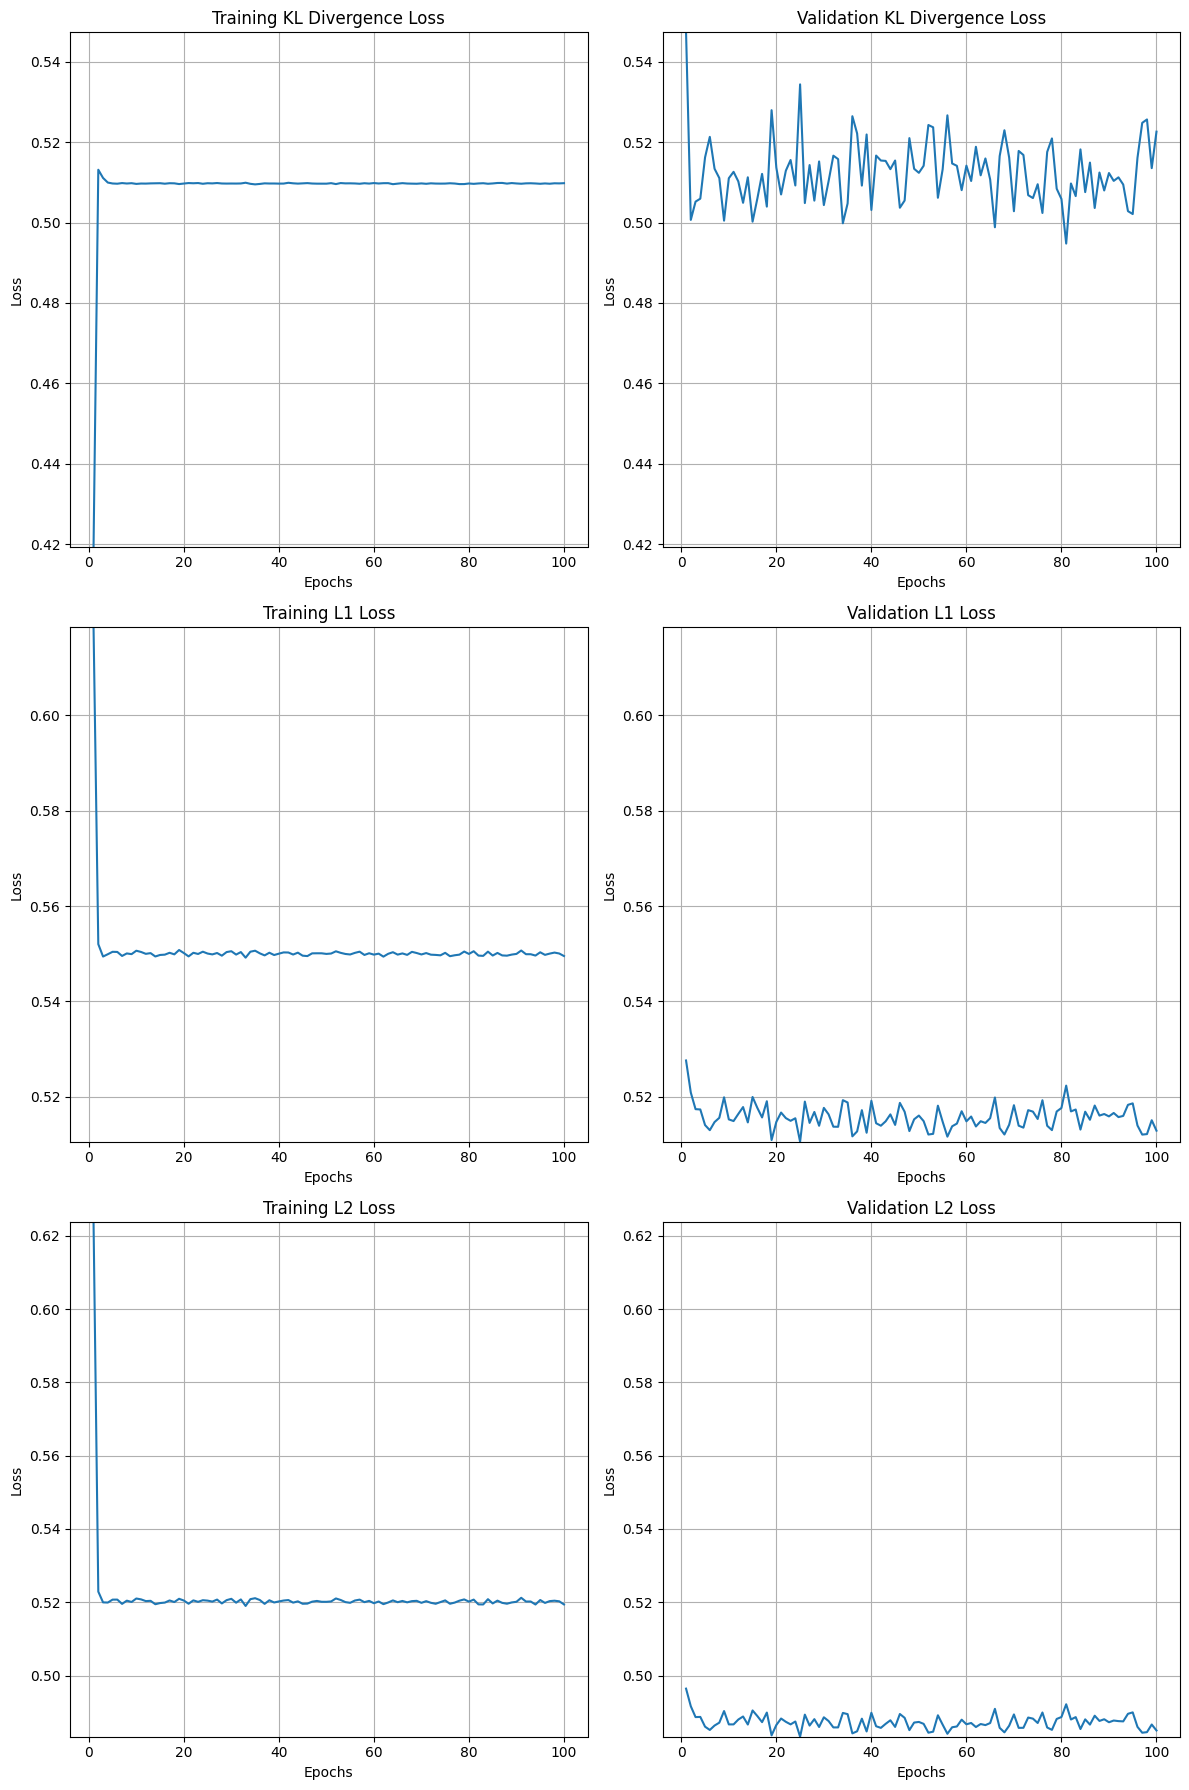

In [13]:
# * * * * * * * * * * * * * * * *
# Plot Losses
# * * * * * * * * * * * * * * * *
PlotLosses(losses, EPOCHS, model_dir)
SaveLossesToCSV(losses, os.path.join(model_dir, "losses.csv"))

In [14]:
# * * * * * * * * * * * * * * * *
# Best Validation Loss
# * * * * * * * * * * * * * * * *
PrintAndLog(log_filepath, "Best Validation Loss in Kelvins:\n")
PrintAndLog(
	log_filepath,
	f"\t{min(losses['val_l1_losses'])*x_data_std:.4f} K\n")

Best Validation Loss in Kelvins:
50.8645 K


In [15]:
# * * * * * * * * * * * * * * * *
# Sample
# * * * * * * * * * * * * * * * *
z_sample = SampleLatentSpace(
	vae,
	test_loader,
	scaler,
	DEVICE,
	model_dir
)

[Sampling]: 100%|██████████| 4/4 [00:09<00:00,  2.25s/it]


z0: -0.0674
z1: 0.0193
z2: 0.0035
z3: 0.0715


Traversing Latent Dimension z3: 100%|██████████| 11/11 [00:00<00:00, 777.01it/s]


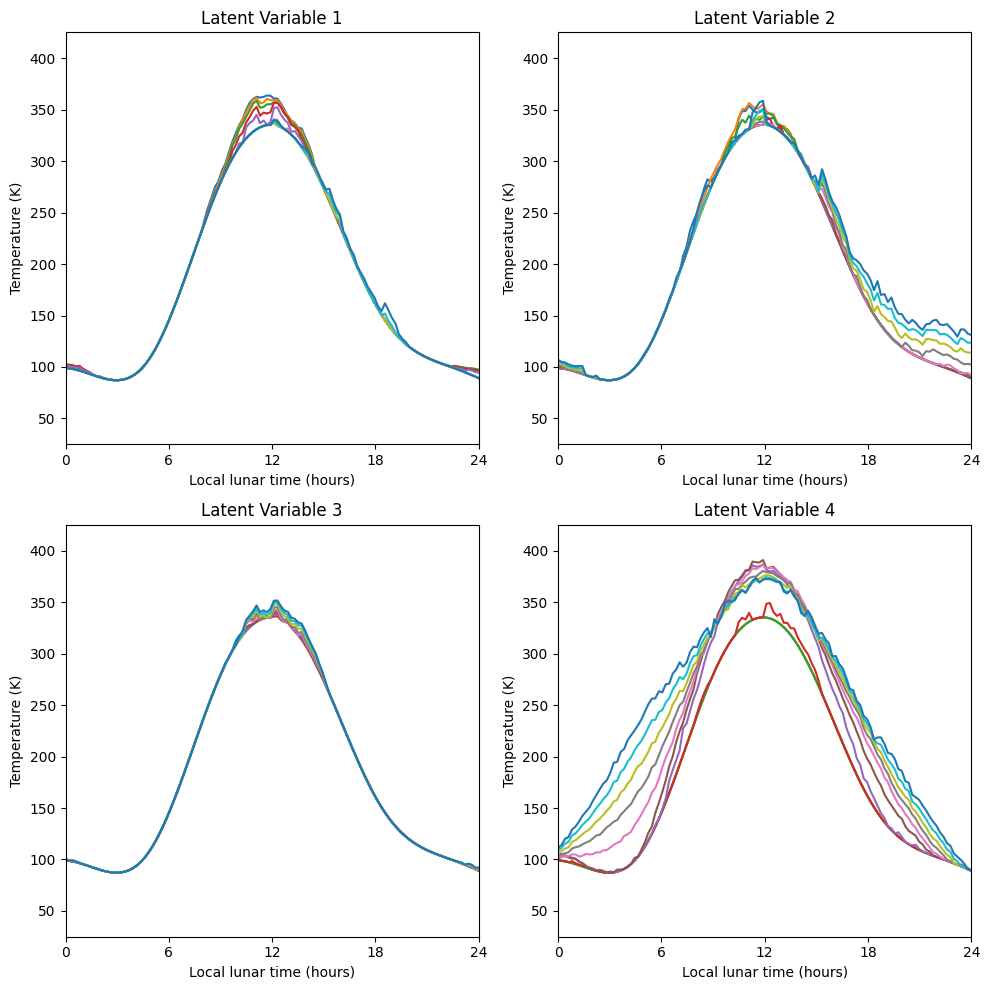

In [16]:
# * * * * * * * * * * * * * * * *
# Analyze Latent Space
# * * * * * * * * * * * * * * * *
mean_latent_vals = GetMeanLatentValues(z_sample, LATENT_DIM)
for i in range(LATENT_DIM):
	print(f"z{i}: {mean_latent_vals[i]:.4f}")

VisualizeLatentSpace(
	vae, LATENT_DIM, z_sample,
	scaler, DEVICE, model_dir)